In [1]:
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline


import flotilla
sns.set(style='ticks', context='talk')

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure1_expression'

study = flotilla.embark('singlecell_pnm_0.3')

2015-09-24 11:53:54	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_0.3/datapackage.json
2015-09-24 11:53:54	Parsing datapackage to create a Study object
2015-09-24 11:54:30	Initializing Study
2015-09-24 11:54:30	Initializing Predictor configuration manager for Study
2015-09-24 11:54:30	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-09-24 11:54:30	Added ExtraTreesClassifier to default predictors
2015-09-24 11:54:30	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-09-24 11:54:30	Added ExtraTreesRegressor to default predictors
2015-09-24 11:54:30	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-09-24 11:54:30	Added GradientBoostingClassifier to default predictors
2015-09-24 11:54:30	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoo

In [2]:
study.splicing.data.head()

,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193740-100193848:-,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514307:+,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,...,exon:chrY:21903621-21903743:-@exon:chrY:21903204-21903374:-@exon:chrY:21901414-21901548:-,exon:chrY:22744476-22744579:+@exon:chrY:22746360-22746410:+@exon:chrY:22749910-22749991:+,exon:chrY:22744476-22744579:+@exon:chrY:22746360-22746410:+@exon:chrY:22749910-22750415:+,exon:chrY:2709527-2709668:+@exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+,exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+,exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+,exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+,exon:chrY:2722771-2722812:+@exon:chrY:2733129-2733286:+@exon:chrY:2734834-2734903:+,exon:chrY:2722771-2722812:+@exon:chrY:2733129-2733286:+@exon:chrY:2734834-2734997:+,exon:chrY:2722771-2722812:+@exon:chrY:2733129-2733286:+@exon:chrY:2734834-2735309:+
CVN_01,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,1,...,NaN,NaN,NaN,1,1,1,1,1,1,1
CVN_02,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_03,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVN_04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,1,1,1,1,1
CVN_05,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,...,NaN,1,1,1,1,1,1,1,1,1


In [3]:
study.splicing.data.shape

(233, 37818)

In [4]:
study.splicing.data_original.shape

(233, 53192)

### Reads mapped

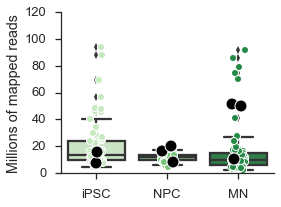

In [5]:
sns.set(style='ticks', context='talk')
millions_mapped = study.mapping_stats.number_mapped/1e6
millions_mapped = millions_mapped.to_frame().join(study.metadata.data[['pooled', 'phenotype']])

millions_mapped_pooled = millions_mapped.ix[millions_mapped.pooled]
millions_mapped_single = millions_mapped.ix[~millions_mapped.pooled]

fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(x='phenotype', y='Uniquely mapped reads number', order=study.phenotype_order, 
               data=millions_mapped_single, palette=study.phenotype_color_ordered)
sns.stripplot(x='phenotype', y='Uniquely mapped reads number', order=study.phenotype_order,
               data=millions_mapped_single, palette=study.phenotype_color_ordered, jitter=True)
sns.stripplot(x='phenotype', y='Uniquely mapped reads number', order=study.phenotype_order,
              data=millions_mapped_pooled, color='k', size=12, jitter=True)
sns.despine()
ax.set_xlabel('')
ax.set_ylabel('Millions of mapped reads')
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
fig.tight_layout()
fig.savefig("/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure1_expression/mapped_reads_violins.pdf")

## Predict outliers of celltype using $k$-means outliers

In [6]:
%%time
from sklearn.cluster import KMeans

#
expression_singles = study.expression.singles.dropna(axis=0, how='all')

# run k-means clustering
km = KMeans(init='k-means++', n_clusters=3, n_init=1000)
km.fit(expression_singles)


CPU times: user 5min 24s, sys: 0 ns, total: 5min 24s
Wall time: 5min 26s


### Determine group membership

In [7]:
from collections import defaultdict

# determine group membership
 
km_membership = dict(zip(expression_singles.index, km.labels_))
 
km_groups = defaultdict(list)
for sample in km_membership:
    km_groups[km_membership[sample]].append(study.sample_id_to_phenotype[sample])
    
# determine group outliers based on majority membership of cell type
km_outliers = []
 
km_colors = []
group_to_color = {}
for label in km_groups:
    lst = km_groups[label]
    most_common =  max(set(lst), key=lst.count)
    for sample in km_membership:
        sample_phenotype = study.sample_id_to_phenotype[sample]
        if sample_phenotype != most_common and km_membership[sample] == label:
            km_outliers.append(sample)

for x in sorted(km_outliers):
    print x

M1_03
M1_04
M2_01
M2_02
M2_06
M2_07
M3_01
M3_03
M4_13
M6_02
N1_06
N1_09
N2_06
N4_10
P2_06


Remove the outliers

In [8]:
study.metadata.data['outlier'] = study.metadata.data.index.isin(km_outliers)
study.drop_outliers()
study.save('singlecell_pnm_figure1_post_kmeans_outliers')

Wrote datapackage to /home/obotvinnik/flotilla_projects/singlecell_pnm_figure1_post_kmeans_outliers/datapackage.json


/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['gene_type', 'gene_name', 'gencode_transcript', 'ensembl_transcript', 'ensembl_gene', 'gencode_gene', 'splice_type', 'biomark_neural_panel', 'confident_rbp', 'rbp', 'ribosomal', 'ribosomal_subunit', 'synapse', 'transcription_factor', 'gerstberger2014_rbp_consensus_rna_target', 'miRNA_primary_transcript', 'exon2_overlapping_repeats', 'exon2_overlapping_repeats_unique', 'reading_frame', 'exon3_3p_splice_site_seq', 'exon2_3p_splice_site_seq', 'exon1_5p_splice_site_seq', 'exon2_5p_splice_site_seq', 'exon1_exon2_splice_signals', 'exon2_exon3_splice_signals', 'exon1_exon3_splice_signals', 'exon2_frame0_translation', 'exon2_frame1_translation', 'exon2_frame2_translation', 'exon2_frame0_stop_codon', 'exon2_frame1_stop_codon', 'exon2_frame2_